# 07_bayesian_network — Probabilistic Decision Support
A compact **Bayesian Network (BN)** that fuses hydrology + text flags + GP forecast to infer **spill / shortfall / high‑load** risks and a suggested **decision**.

**Inputs**
- `master_with_topics.csv` (features + flags)
- `predictions_test.csv` (from 05_modeling; provides `gpr_mean`, `gpr_std`)

**Outputs**
- `bn_inference.csv` with marginal posteriors per day


### Cell 1 — Imports & configuration

In [10]:
### Cell 1 — Imports & configuration

import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import norm

# Bayesian Network library (pgmpy)
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

plt.rcParams['figure.figsize'] = (11,4)

FEATURES_PATH = "master_with_topics.csv"
PRED_PATH     = "predictions_test.csv"

print(Path(FEATURES_PATH).resolve())
print(Path(PRED_PATH).resolve())


C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\master_with_topics.csv
C:\Users\abhis\Desktop\Big Data\Hydropower decision support system\predictions_test.csv


In [2]:
!pip install pgmpy

  Using cached pgmpy-1.0.0-py3-none-any.whl.metadata (9.4 kB)
  Using cached torch-2.8.0-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached statsmodels-0.14.5-cp311-cp311-win_amd64.whl.metadata (9.8 kB)
  Using cached pyro_ppl-1.9.1-py3-none-any.whl.metadata (7.8 kB)
Using cached pgmpy-1.0.0-py3-none-any.whl (2.0 MB)
Using cached pyro_ppl-1.9.1-py3-none-any.whl (755 kB)
Using cached torch-2.8.0-cp311-cp311-win_amd64.whl (241.4 MB)
Using cached statsmodels-0.14.5-cp311-cp311-win_amd64.whl (9.6 MB)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Cell 2 — Load data, join forecasts, discretize

In [11]:
### Cell 2 — Load data, join forecasts, discretize

df = pd.read_csv(FEATURES_PATH, parse_dates=['date']).sort_values('date')
pred = pd.read_csv(PRED_PATH, parse_dates=['date']) if Path(PRED_PATH).exists() else None

# Detect typical columns
def first_existing(cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

COL_LOAD = first_existing(['load_MW','peak_load_mw','avg_load_mw'])
COL_RAIN = first_existing(['rainfall_mm'])
COL_Q    = first_existing(['discharge_m3s','discharge_cms'])
COL_RES  = first_existing(['reservoir_m','gauge_m'])

# Merge GP forecasts if available, else fallback MA forecast
if pred is not None and {'date','gpr_mean','gpr_std'}.issubset(pred.columns):
    data = df.merge(pred[['date','gpr_mean','gpr_std']], on='date', how='left')
else:
    tmp = df[['date', COL_LOAD]].set_index('date').sort_index().asfreq('D')
    gpr_mean = tmp[COL_LOAD].rolling(7, min_periods=3).mean()
    gpr_std  = (tmp[COL_LOAD] - gpr_mean).rolling(30, min_periods=7).std().fillna(gpr_mean.std())
    fb = pd.DataFrame({'date': gpr_mean.index, 'gpr_mean': gpr_mean.values, 'gpr_std': gpr_std.values})
    data = df.merge(fb, on='date', how='left')

data = data.sort_values('date').reset_index(drop=True)

# Capacity/min bound for derived binary nodes
cap_mw = data[COL_LOAD].quantile(0.95) if COL_LOAD else data['gpr_mean'].quantile(0.95)
min_mw = data[COL_LOAD].quantile(0.10) if COL_LOAD else data['gpr_mean'].quantile(0.10)

from scipy.stats import norm
import numpy as np
import pandas as pd

# Utility: default series with same index
zero_series = lambda: pd.Series(0, index=data.index)

# Seasonal normalization
def z_monthly(s):
    s = s.copy()
    g = data['date'].dt.month
    m = s.groupby(g).transform('mean')
    sd = s.groupby(g).transform('std').replace(0, np.nan)
    return (s - m) / sd

# Hydrology & flags
data['RainHigh']      = (z_monthly(data.get(COL_RAIN,  zero_series())) > 0.7).astype(int)
data['DischargeHigh'] = (z_monthly(data.get(COL_Q,     zero_series())) > 0.7).astype(int)
data['ReservoirHigh'] = (z_monthly(data.get(COL_RES,   zero_series())) > 0.7).astype(int)
data['FloodFlag']     = data.get('flood_flag', 0).astype(int)
data['WeatherFlag']   = data.get('weather_flag', 0).astype(int)
data['MaintFlag']     = (data.get('maintenance_flag',0) + data.get('outage_flag',0)).clip(0,1).astype(int)

# GP-based risks (tail probabilities)
z_hi = (cap_mw - data['gpr_mean']) / data['gpr_std'].replace(0, np.nan)
z_lo = (data['gpr_mean'] - min_mw) / data['gpr_std'].replace(0, np.nan)

prob_highload  = 1 - norm.cdf(np.nan_to_num(z_hi.values, nan=0.0))
prob_shortfall = 1 - norm.cdf(np.nan_to_num(z_lo.values, nan=0.0))

def binarize_prob(p, thr=0.5):
    return (np.asarray(p) >= thr).astype(int)

data['GP_HighLoad']  = binarize_prob(prob_highload,  0.5)
data['GP_Shortfall'] = binarize_prob(prob_shortfall, 0.5)

# Targets (latent risks as categories)
data['RiskSpill']     = ((data['RainHigh'] | data['DischargeHigh'] | data['FloodFlag'] | data['WeatherFlag']) > 0).astype(int)
data['RiskShortfall'] = data['GP_Shortfall']
data['RiskHighLoad']  = data['GP_HighLoad']

keep_cols = ['date','RainHigh','DischargeHigh','ReservoirHigh','FloodFlag','WeatherFlag','MaintFlag',
             'GP_HighLoad','GP_Shortfall','RiskSpill','RiskShortfall','RiskHighLoad']
bn_df = data[keep_cols].dropna().reset_index(drop=True)
bn_df.head()


,date,RainHigh,DischargeHigh,ReservoirHigh,FloodFlag,WeatherFlag,MaintFlag,GP_HighLoad,GP_Shortfall,RiskSpill,RiskShortfall,RiskHighLoad
0,2019-01-31,0,0,0,0,0,0,1,1,0,1,1
1,2019-02-01,0,0,0,0,0,0,1,1,0,1,1
2,2019-02-02,0,0,0,0,0,0,1,1,0,1,1
3,2019-02-03,0,0,0,0,0,0,1,1,0,1,1
4,2019-02-04,0,0,0,0,0,0,1,1,0,1,1


### Cell 3 — Define Bayesian Network structure

In [13]:
# Structure (expert prior): 
# Rain/Discharge/Weather → RiskSpill
# GP_* → corresponding risks
# MaintFlag + RiskSpill/RiskHighLoad → Decision
edges = [
    ('RainHigh','RiskSpill'),
    ('DischargeHigh','RiskSpill'),
    ('WeatherFlag','RiskSpill'),
    ('FloodFlag','RiskSpill'),
    ('GP_Shortfall','RiskShortfall'),
    ('GP_HighLoad','RiskHighLoad'),
    ('MaintFlag','RiskHighLoad'),
    ('MaintFlag','RiskShortfall'),
]

model = DiscreteBayesianNetwork(edges)
model

### Cell 4 — Learn CPDs (Maximum Likelihood)

In [18]:
### Cell 4 — Learn CPDs (BayesianEstimator with Dirichlet priors, robust to sparsity)

from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

# All variables are binary (0/1) here
data_disc = bn_df.drop(columns=['date'])

# Use BayesianEstimator with weak Dirichlet priors (equivalent sample size = 2)
try:
    model.fit(
        data_disc,
        estimator=BayesianEstimator,
        prior_type="dirichlet",
        pseudo_counts=2  # small smoothing; increase if very sparse
    )
    used = "BayesianEstimator (Dirichlet, pseudo_counts=2)"
except Exception as e:
    print("BayesianEstimator fit failed, falling back to MLE. Reason:", e)
    model.fit(data_disc, estimator=MaximumLikelihoodEstimator)
    used = "MaximumLikelihoodEstimator (MLE)"

print("CPDs learned with:", used)
for cpd in model.get_cpds():
    print(cpd.variable, "— states:", cpd.state_names)
    print(cpd)


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'RainHigh': 'N', 'DischargeHigh': 'N', 'ReservoirHigh': 'N', 'FloodFlag': 'N', 'WeatherFlag': 'N', 'MaintFlag': 'N', 'GP_HighLoad': 'N', 'GP_Shortfall': 'N', 'RiskSpill': 'N', 'RiskShortfall': 'N', 'RiskHighLoad': 'N'}


CPDs learned with: BayesianEstimator (Dirichlet, pseudo_counts=2)
RainHigh — states: {'RainHigh': [0, 1]}
+-------------+-----------+
| RainHigh(0) | 0.915556  |
+-------------+-----------+
| RainHigh(1) | 0.0844444 |
+-------------+-----------+
RiskSpill — states: {'RiskSpill': [0, 1], 'DischargeHigh': [0, 1], 'FloodFlag': [0, 1], 'RainHigh': [0, 1], 'WeatherFlag': [0, 1]}
+---------------+-----------------------+-----+------------------+------------------+
| DischargeHigh | DischargeHigh(0)      | ... | DischargeHigh(1) | DischargeHigh(1) |
+---------------+-----------------------+-----+------------------+------------------+
| FloodFlag     | FloodFlag(0)          | ... | FloodFlag(1)     | FloodFlag(1)     |
+---------------+-----------------------+-----+------------------+------------------+
| RainHigh      | RainHigh(0)           | ... | RainHigh(1)      | RainHigh(1)      |
+---------------+-----------------------+-----+------------------+------------------+
| WeatherFlag   | Wea

### Cell 5 — Inference: compute daily marginals

In [19]:
infer = VariableElimination(model)

# Evidence per-day: treat observed parents as evidence, infer posteriors for risks
out_rows = []
for _, r in bn_df.iterrows():
    evidence = {
        'RainHigh': int(r['RainHigh']),
        'DischargeHigh': int(r['DischargeHigh']),
        'WeatherFlag': int(r['WeatherFlag']),
        'FloodFlag': int(r['FloodFlag']),
        'GP_Shortfall': int(r['GP_Shortfall']),
        'GP_HighLoad': int(r['GP_HighLoad']),
        'MaintFlag': int(r['MaintFlag']),
    }
    q_spill = infer.query(['RiskSpill'], evidence=evidence, show_progress=False)
    q_short = infer.query(['RiskShortfall'], evidence=evidence, show_progress=False)
    q_high  = infer.query(['RiskHighLoad'], evidence=evidence, show_progress=False)

    out_rows.append({
        'date': r['date'],
        'P(RiskSpill=1)': float(q_spill.values[1]),
        'P(RiskShortfall=1)': float(q_short.values[1]),
        'P(RiskHighLoad=1)': float(q_high.values[1]),
    })

bn_post = pd.DataFrame(out_rows)
bn_post.head()

,date,P(RiskSpill=1),P(RiskShortfall=1),P(RiskHighLoad=1)
0,2019-01-31,0.00147,0.998588,0.998588
1,2019-02-01,0.00147,0.998588,0.998588
2,2019-02-02,0.00147,0.998588,0.998588
3,2019-02-03,0.00147,0.998588,0.998588
4,2019-02-04,0.00147,0.998588,0.998588


### Cell 6 — Map BN posteriors → decision

In [20]:
THR_HIGH, THR_MED = 0.6, 0.35

def decide(p_spill, p_short, p_high):
    if p_spill >= THR_HIGH:
        return 'Spill advisory'
    if p_short >= THR_HIGH:
        return 'Shortfall mitigation (imports/DR)'
    if p_high >= THR_HIGH:
        return 'Peak support readiness'
    # medium levels
    if p_spill >= THR_MED:
        return 'Monitor spill readiness'
    if p_short >= THR_MED:
        return 'Monitor shortfall'
    if p_high >= THR_MED:
        return 'Monitor peak load'
    return 'Normal ops'

bn_post['decision'] = [decide(a,b,c) for a,b,c in bn_post[['P(RiskSpill=1)','P(RiskShortfall=1)','P(RiskHighLoad=1)']].values]
bn_post.to_csv('bn_inference.csv', index=False)
print("Saved bn_inference.csv | rows:", len(bn_post))
bn_post.head(10)

Saved bn_inference.csv | rows: 1796


,date,P(RiskSpill=1),P(RiskShortfall=1),P(RiskHighLoad=1),decision
0,2019-01-31,0.001470,0.998588,0.998588,Shortfall mitigation (imports/DR)
1,2019-02-01,0.001470,0.998588,0.998588,Shortfall mitigation (imports/DR)
2,2019-02-02,0.001470,0.998588,0.998588,Shortfall mitigation (imports/DR)
3,2019-02-03,0.001470,0.998588,0.998588,Shortfall mitigation (imports/DR)
4,2019-02-04,0.001470,0.998588,0.998588,Shortfall mitigation (imports/DR)
5,2019-02-05,0.001470,0.998588,0.998588,Shortfall mitigation (imports/DR)
6,2019-02-06,0.001470,0.998588,0.998588,Shortfall mitigation (imports/DR)
7,2019-02-07,0.001470,0.998588,0.998588,Shortfall mitigation (imports/DR)
8,2019-02-08,0.992481,0.998588,0.998588,Spill advisory
9,2019-02-09,0.963636,0.998588,0.998588,Spill advisory


### Cell 7 — Visualize posteriors

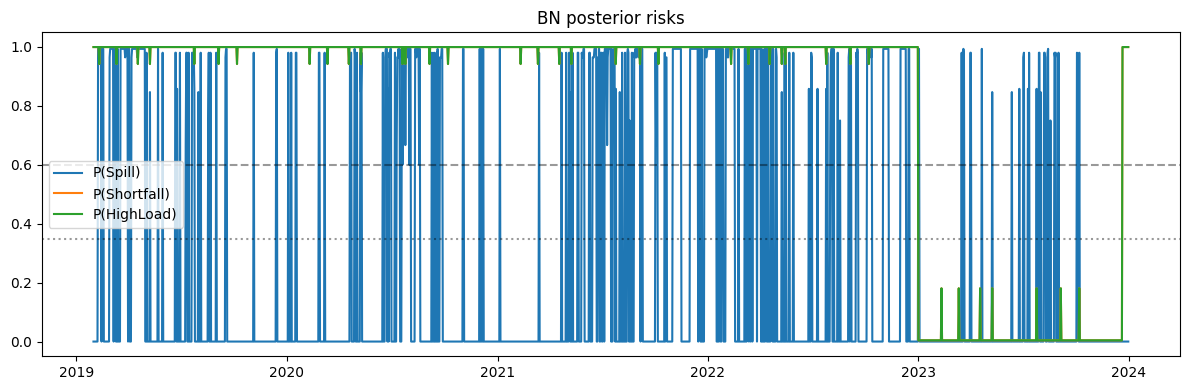

In [21]:
plt.figure(figsize=(12,4))
plt.plot(bn_post['date'], bn_post['P(RiskSpill=1)'], label='P(Spill)')
plt.plot(bn_post['date'], bn_post['P(RiskShortfall=1)'], label='P(Shortfall)')
plt.plot(bn_post['date'], bn_post['P(RiskHighLoad=1)'], label='P(HighLoad)')
plt.axhline(0.6, color='k', ls='--', alpha=0.4); plt.axhline(0.35, color='k', ls=':', alpha=0.4)
plt.legend(); plt.title('BN posterior risks'); plt.tight_layout(); plt.show()